In [1]:
### Init network Build
import numpy as np
import re
from pathlib import Path
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display
import pandas as pd
from osgeo import gdal
import keras
import time
import tensorflow as tf
print(tf.__version__, 'tf')
print(keras.__version__, 'keras')


2.3.0 tf
2.4.3 keras


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 853589566406865967
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 845565957525164562
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18083544255607979166
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11005587648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14570522297477480943
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
#2.4.1 tf
#2.4.3 keras

In [ ]:
#!nvidia-smi

In [3]:
from google.cloud import storage
# create a service key json file and point to it here,   I will put a copy of the .json key I am using in slack.
storage_client = storage.Client.from_service_account_json('access_key1.json')  # create a service key json file and point to it here

bucket_name = 'pollutemenot-ai'
bucket = storage_client.get_bucket(bucket_name)

In [4]:
#download files
t0 = time.time()
prefix = 'GEE_images_final2/'
dl_dir = '/data/image_final2/'
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files

In [5]:
type(blobs)

google.api_core.page_iterator.HTTPIterator

In [7]:
x = list(blobs)
print(len(x))

87622


In [14]:
print(x[0].time_created)
print(x[0].id)

dir(x[0])

2021-03-07 00:25:53.690000+00:00
pollutemenot-ai/GEE_images_final2/hires/gmndwi/1000_LRE-2019-00318-120_gmndwi_hires.tif/1615076753685633


['STORAGE_CLASSES',
 '_CHUNK_SIZE_MULTIPLE',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_acl',
 '_bucket',
 '_changes',
 '_chunk_size',
 '_do_download',
 '_do_multipart_upload',
 '_do_resumable_upload',
 '_do_upload',
 '_encryption_headers',
 '_encryption_key',
 '_extract_headers_from_download',
 '_get_content_type',
 '_get_download_url',
 '_get_transport',
 '_get_upload_arguments',
 '_get_writable_metadata',
 '_initiate_resumable_upload',
 '_patch_property',
 '_properties',
 '_query_params',
 '_require_client',
 '_set_properties',
 'acl',
 'bucket',
 'cache_control',
 'chunk_size',
 'client',
 'component_count',
 'compose',
 'content_disposition',
 'content_enco

In [23]:
#download files
t0 = time.time()
prefix = 'GEE_images_final2/'
dl_dir = '/data/image_final2/'

In [2]:
dl_dir = '/data/image_final2/'

tif_list = [f for f in Path(dl_dir).iterdir() if '.tif' in str(f)]
print(len(tif_list))
#tif_list 15321

87647


In [9]:
datapath = "Madhukar/Archived/Data_combined_regular_clean.csv"
df_labels = pd.read_csv(datapath, encoding = "ISO-8859-1")
df_labels.head()#.iloc[99]
df_labels = df_labels[['da_number', 'cwa_determination']]
print(df_labels.shape)
df_labels.head()

(14619, 2)


,da_number,cwa_determination
0,LRB-1983-10120,0
1,LRB-1985-69031,1
2,LRB-1986-99614,1
3,LRB-1990-97632,1
4,LRB-1991-98611,1


In [10]:
def create_image_lookup(tiff_image_list):
    
    t0 = time.time()
    list_rows = []
    for v in tiff_image_list:
        #print(v)
        #nl = v.name.split('_')[3:7]
        nll = re.split('_|-',str(v))
        nl = nll[4:7]
        #print(nl)
        #print('-'.join(nll[7:-2]))
        nl.append('-'.join(nll[7:-2])) # rejoin the da num and append da num
        nl.append(v)
        #print(nl)
        list_rows.append(nl)
        
    columns = ['img_res', 'img_type', 'img_index', 'da_num', 'img_path']
    df = pd.DataFrame(list_rows, columns = columns)
    print('dataframe shape:', df.shape)
    print('seconds taken:', time.time()-t0)
    return df
df = create_image_lookup(tif_list)
df.head()

dataframe shape: (87647, 5)
seconds taken: 0.5849359035491943


,img_res,img_type,img_index,da_num,img_path
0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...
1,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...
2,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...
3,lores,gmndwi,5824,NAN-2016-00095-USH,/data/image_final2/GEE_images_final2_lores_gmn...
4,hires,srtm,1436,LRL-2016-00917-htm,/data/image_final2/GEE_images_final2_hires_srt...


In [11]:
df_merged = pd.merge(df, df_labels, left_on = 'da_num', right_on = 'da_number', how = 'left')
print(df_merged.shape)
print(df_merged.img_path.iloc[0])
df_merged.head()

(87647, 7)
/data/image_final2/GEE_images_final2_lores_mndwi_292_LRC-2003-22227_mndwi_lores.tif


,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination
0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1
1,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0
2,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...,MVP-2020-00252-MHK,0
3,lores,gmndwi,5824,NAN-2016-00095-USH,/data/image_final2/GEE_images_final2_lores_gmn...,NAN-2016-00095-USH,0
4,hires,srtm,1436,LRL-2016-00917-htm,/data/image_final2/GEE_images_final2_hires_srt...,LRL-2016-00917-htm,0


In [12]:
xx = df_merged.img_path.apply(lambda x: re.split('_',str(x)))
xxl = xx.apply(lambda x: len(x))
xxl.value_counts()
print(df_merged[xxl == 10].img_path.iloc[0])

/data/image_final2/GEE_images_final2_lores_mndwi_292_LRC-2003-22227_mndwi_lores.tif


In [13]:
print(df_merged.cwa_determination.isna().value_counts())
df_merged.cwa_determination.value_counts()

False    87647
Name: cwa_determination, dtype: int64


0    57439
1    30208
Name: cwa_determination, dtype: int64

In [79]:
for da, dadf in df_merged.groupby('da_num'):
    if dadf.shape[0] != 10:
        print(dadf.shape[0], da)

9 LRB-2004-00299
5 LRC-2017-00372
5 LRC-2017-00378
5 LRC-2017-00391
5 LRC-2017-00466
6 LRC-2018-00021
5 LRC-2018-00038
7 LRC-2019-00994
7 LRC-2019-01019
7 LRC-2019-01021
7 LRC-2019-01027
8 LRC-2019-01040
7 LRC-2019-01052
7 LRC-2019-01054
7 LRC-2019-01056
8 LRC-2019-01057
8 LRC-2020-00024
1 LRC-2020-00347
2 LRC-2020-00354
1 LRC-2020-00365
1 LRC-2020-00371
1 LRC-2020-00372
3 LRC-2020-00373
2 LRC-2020-00397
1 LRC-2020-00422
1 LRE-1987-1020103
1 LRE-1988-161280-16
9 LRH-2015-00966-BCR
9 LRH-2018-00971-GUY
8 LRL-2018-00955
8 LRL-2018-00980-sjk
8 LRL-2018-01001-jlb
8 LRL-2018-01010
8 LRL-2018-01030
9 LRL-2018-01071-LCL
8 LRL-2018-01087-SCM
9 LRL-2018-01090-sjk
8 LRL-2018-01094-LCL
8 LRL-2018-01105-htm
9 LRN-2020-00219
9 LRN-2020-00307
9 LRN-2020-00310
9 LRN-2020-00315
9 LRN-2020-00351
9 LRP-1997-00197
9 LRP-2009-00477
9 LRP-2013-01406
9 LRP-2014-01127
9 LRP-2015-01538
9 MVK-2017-00533-CR
8 MVK-2017-00540-TB
8 MVK-2017-00545-TB
8 MVK-2017-00549-TB
4 MVK-2017-00587-TB
5 MVK-2017-00824-JLD
5 MV

In [14]:
def create_array(tif_image):
    try:
        p = gdal.Open(str(tif_image))
        channels = p.RasterCount

        # iterate through rasters and add each to the list of layer_list
        layer_list = [np.array(p.GetRasterBand(i).ReadAsArray()) for i in range(1,channels+1)] 
    except: 
        print("Error with image:", tif_image)
        return np.nan
    return np.array(layer_list)
create_array('/data/image_final2/GEE_images_final2_hires_mndwi_2105_MVK-2016-00239-LCM_mndwi_hires.tif').shape

(1, 256, 256)

In [15]:
def get_image_metrics(image_path):
    image_arr = create_array(image_path)
    mean_pixel_value = np.nanmean(image_arr)
    std_pixel_value = np.nanstd(image_arr)
    return mean_pixel_value, std_pixel_value

In [16]:
t0 = time.time()
df_merged['metrics'] = df_merged.img_path.apply(get_image_metrics)
print(round(time.time()-t0, 3), 'seconds to finish')
df_merged.head()

Error with image: /data/image_final2/GEE_images_final2_lores_srtm_5857_NAN-2016-01232-USH_srtm_lores.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Error with image: /data/image_final2/GEE_images_final2_lores_gmndwi_8463_SAC-2015-01689_gmndwi_lores.tif
Error with image: /data/image_final2/GEE_images_final2_hires_mndvi_8236_SAC-2012-00032_mndvi_hires.tif
Error with image: /data/image_final2/GEE_images_final2_hires_mndvi_6176_NAO-2016-01643-tca_mndvi_hires.tif
Error with image: /data/image_final2/GEE_images_final2_lores_srtm_3995_MVN-2019-00361-ST_srtm_lores.tif
Error with image: /data/image_final2/GEE_images_final2_lores_gmndwi_8029_POA-2019-00608_gmndwi_lores.tif
Error with image: /data/image_final2/GEE_images_final2_hires_srtm_8029_POA-2019-00608_srtm_hires.tif
485.87 seconds to finish


,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination,metrics
0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1,"(-0.3306894463763968, 0.09898692070930509)"
1,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0,"(-0.40988840562690426, 0.19788100896017022)"
2,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...,MVP-2020-00252-MHK,0,"(211.5080108642578, 18.443937482788826)"
3,lores,gmndwi,5824,NAN-2016-00095-USH,/data/image_final2/GEE_images_final2_lores_gmn...,NAN-2016-00095-USH,0,"(0.56878513, 0.23097283)"
4,hires,srtm,1436,LRL-2016-00917-htm,/data/image_final2/GEE_images_final2_hires_srt...,LRL-2016-00917-htm,0,"(266.44921875, 1.7671324110003224)"


In [17]:
df_merged['mean'] = df_merged.metrics.apply(lambda x: x[0])
df_merged['stdev'] = df_merged.metrics.apply(lambda x: x[1])
df_merged.to_csv('image_metrics_030621.csv')

In [18]:
#df_merged = pd.read_csv('image_metrics_030621.csv')
df_merged.head()

,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination,metrics,mean,stdev
0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1,"(-0.3306894463763968, 0.09898692070930509)",-0.330689,0.098987
1,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0,"(-0.40988840562690426, 0.19788100896017022)",-0.409888,0.197881
2,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...,MVP-2020-00252-MHK,0,"(211.5080108642578, 18.443937482788826)",211.508011,18.443937
3,lores,gmndwi,5824,NAN-2016-00095-USH,/data/image_final2/GEE_images_final2_lores_gmn...,NAN-2016-00095-USH,0,"(0.56878513, 0.23097283)",0.568785,0.230973
4,hires,srtm,1436,LRL-2016-00917-htm,/data/image_final2/GEE_images_final2_hires_srt...,LRL-2016-00917-htm,0,"(266.44921875, 1.7671324110003224)",266.449219,1.767132


processing hires gmndwi // elapsed time 0.443 sec
processing hires mndvi // elapsed time 0.549 sec


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


processing hires mndwi // elapsed time 0.652 sec
processing hires seasonality // elapsed time 0.752 sec
processing hires srtm // elapsed time 0.854 sec
processing hires transition // elapsed time 0.954 sec
processing lores gmndwi // elapsed time 1.071 sec
processing lores mndvi // elapsed time 1.171 sec
processing lores mndwi // elapsed time 1.269 sec
processing lores srtm // elapsed time 1.37 sec


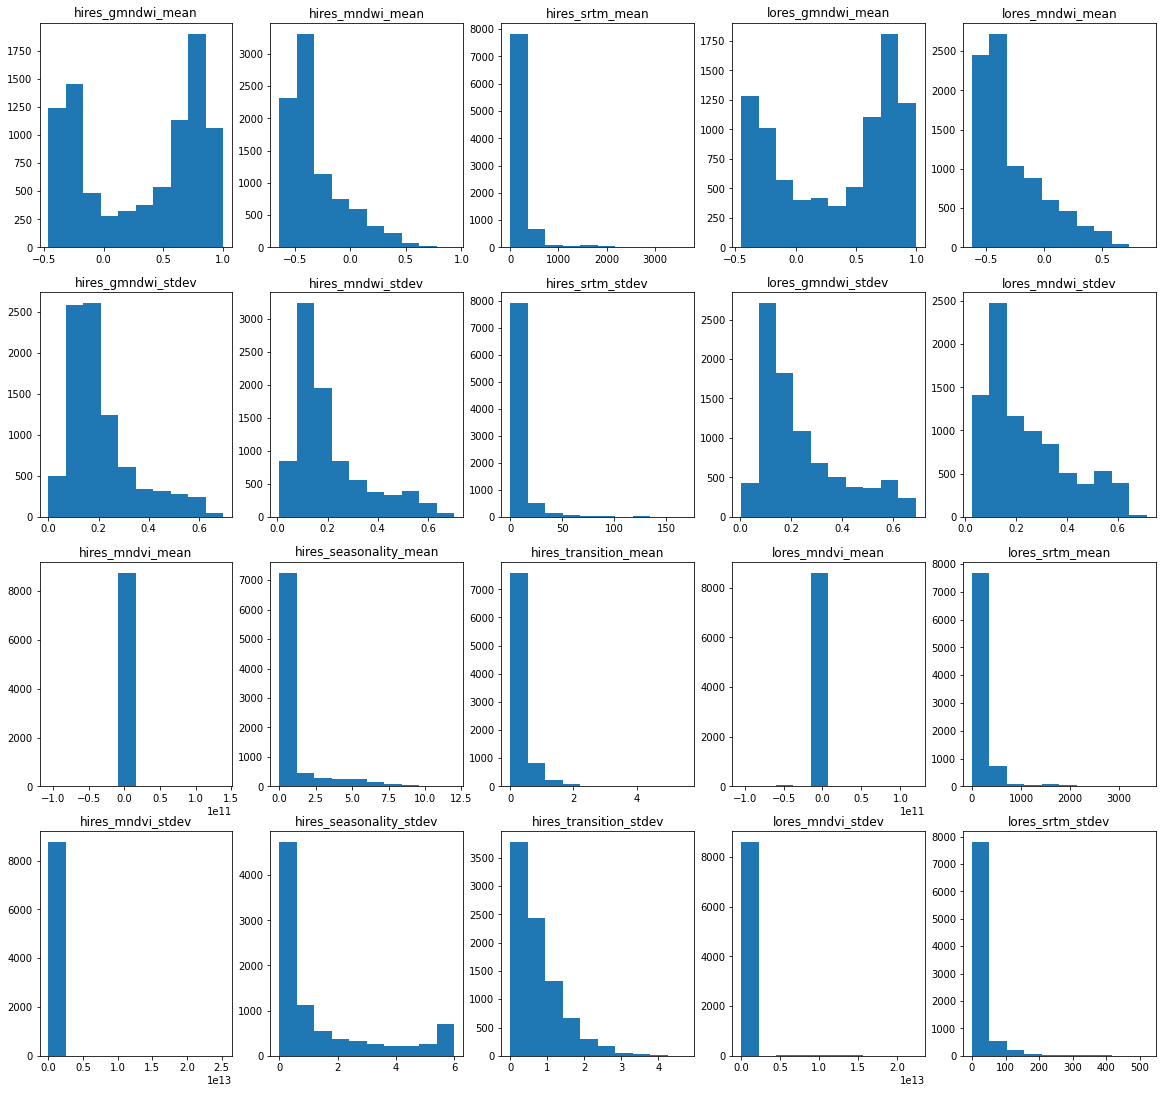

In [19]:
t0 = time.time()
fig, ax = plt.subplots(4,5, figsize = (20,19))
i = 0 
axes = [(x,y) for y in range(5) for x in range(4)]
for res, resdf in df_merged.groupby('img_res'):
    for it, itdf in resdf.groupby('img_type'):
        print('processing', res, it, r'// elapsed time', round(time.time()-t0,3), 'sec')
        ax[axes[i]].hist(list(itdf['mean']))
        ax[axes[i]].set_title(res + '_' + it + '_mean')
        i += 1
        ax[axes[i]].hist(list(itdf['stdev']))
        ax[axes[i]].set_title(res + '_' + it + '_stdev')
        i += 1

In [26]:
layer_setup = [['hires', 'gmndwi'], ['hires', 'mndvi'], ['hires', 'srtm'], # branch 1 hires
               ['hires', 'mndwi'], ['hires', 'seasonality'], ['hires', 'transition'], # branch 2 hires
               ['lores', 'gmndwi'], ['lores', 'mndvi'], ['lores', 'srtm'], ['lores', 'mndwi']] #, branch 3 lores
               #['lores', 'mndwi'], ['lores', 'mndvi'], ['lores', 'srtm']] # branch 4 lores
mean_inception = []
max_values = []
for ir, it in layer_setup:
    #print(ir,it)
    sdf = df_merged[(df_merged.img_type == it)&(df_merged.img_res == ir)]
    print(sdf.shape)
    mean_of_means = np.mean(sdf['mean'])
    mean_inception.append(mean_of_means)
    #
mean_inception        

(8789, 10)
(8801, 10)
(8804, 10)
(8792, 10)
(8786, 10)
(8775, 10)
(8693, 10)
(8754, 10)
(8726, 10)
(8727, 10)


[0.31708574189674105,
 47607068.989010304,
 200.02931837736037,
 -0.30575607199236937,
 0.8324336419473497,
 0.22956766242654914,
 0.3398213538480746,
 -202539432.81945238,
 207.190012307847,
 -0.2742516691454699]

10 images found.


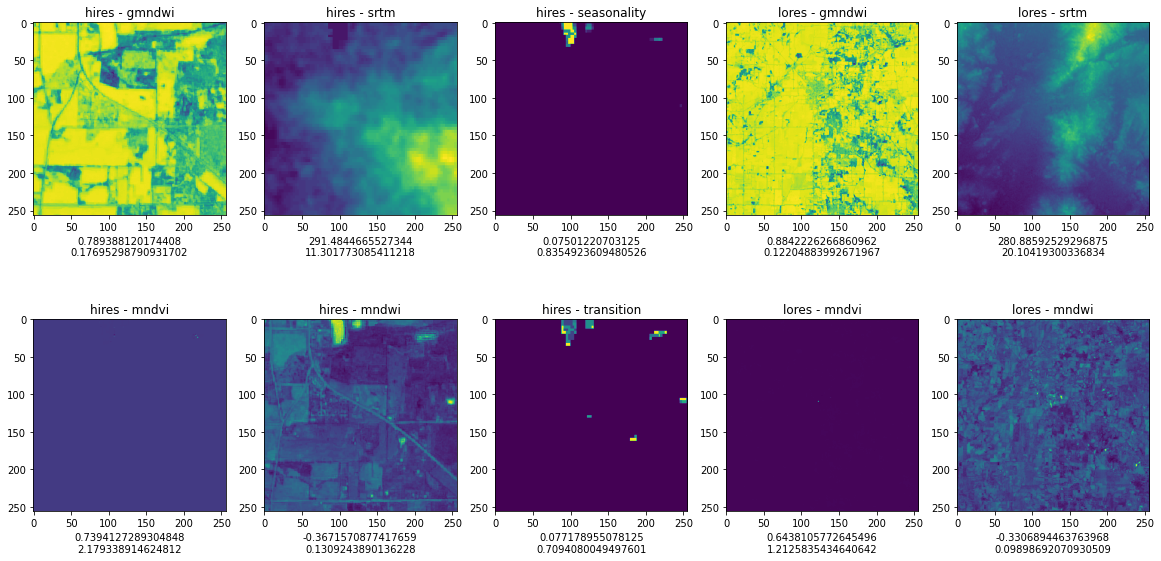

In [21]:
def showdaimages(da_num, il_df, image_order = None):
    t0 = time.time()
    df = il_df[il_df['da_num'] == da_num]
    print(df.shape[0], 'images found.')
    fig, ax = plt.subplots(2,5, figsize = (20,10))
    i = 0 
    axes = [(x,y) for y in range(5) for x in range(2)]
    #for idx, row in df.iterrows():
    for ir, it in layer_setup:
        #print(ir,it)
        row = df[(df.img_type == it)&(df.img_res == ir)].iloc[0]
        i_arr = create_array(row['img_path'])
        i_arr = i_arr.reshape(256,256)
        ax[axes[i]].imshow(i_arr)
        ax[axes[i]].set_title(row['img_res'] + ' - ' + row['img_type'])
        ax[axes[i]].set_xlabel(str(row['mean']) + '\n' + str(row['stdev']))
       # print(row['img_type'])
        i += 1
        #print('_*_*_*_*_*_*_*_*_*_*_*')
        
showdaimages('LRC-2003-22227', df_merged)

MVP-2018-02252-AIS
10 images found.


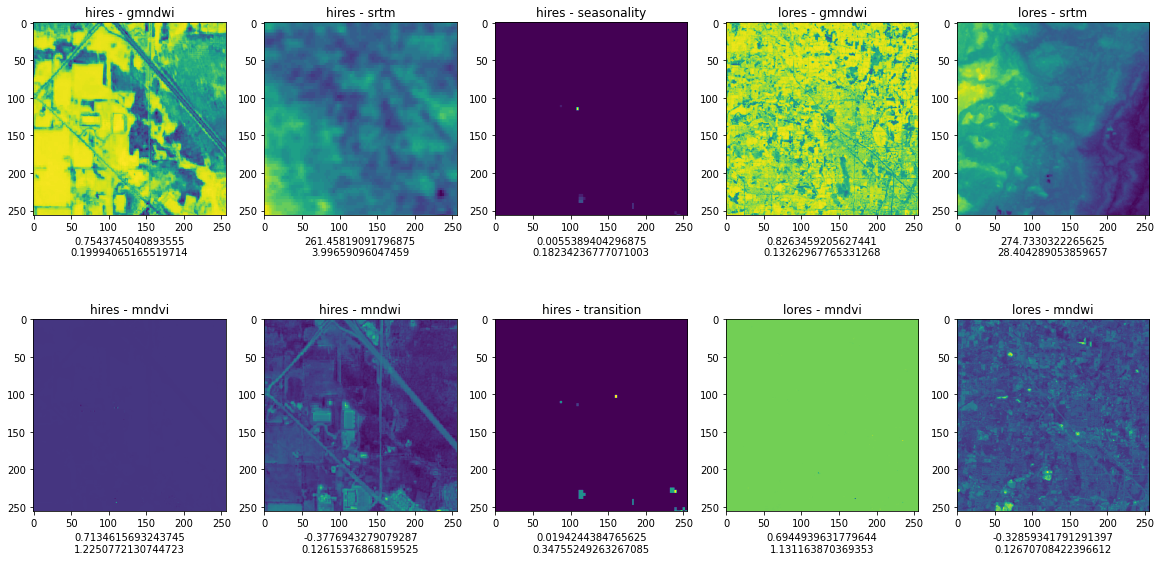

In [22]:
random_da = df_merged.sample()['da_num'].iloc[0]
print(random_da)
showdaimages(random_da, df_merged)

In [27]:
layer_setup = [['hires', 'gmndwi'], ['hires', 'mndvi'], ['hires', 'srtm'], # branch 1 hires
               ['hires', 'mndwi'], ['hires', 'seasonality'], ['hires', 'transition'], # branch 2 hires
               ['lores', 'gmndwi'], ['lores', 'mndvi'], ['lores', 'srtm']] #, branch 3 lores
def save_arrays(df_lookup, layer_setup, location_save):
    t0 = time.time()
    array_count = 0
    for da_num, ddf in df_lookup.groupby('da_num'):
        if ddf.shape[0] != 10:
            print(da_num, "error, not 10 images. ", end = " - ")
            continue
            
        else:
            try:
                stacked_images = []
                for channel in layer_setup:
                    image_row = ddf[(ddf['img_res'] == channel[0])&(ddf['img_type'] == channel[1])]
                    #print(image_row, type(image_row))
                    if image_row.shape[0] != 1: 
                        print('Duplicates?', image_row)
                    stacked_images.append(create_array(image_row.img_path.iloc[0]))
                print(da_num, end = '\r')
                np.save(location_save + str(da_num) + '.npy', np.concatenate(stacked_images))

            except:
                print('error in', da_num)
            array_count += 1

            #break
    print(array_count, 'training examples prepared in', round(time.time()-t0), 'sec')
    return 1
    
    
save_arrays(df_merged, layer_setup, '/data/training_data1/')


Error with image: /data/image_final2/GEE_images_final2_lores_srtm_3995_MVN-2019-00361-ST_srtm_lores.tif error, not 10 images.  - MVN-2018-00129-SK error, not 10 images.  - MVN-2018-00132-SG error, not 10 images.  - MVN-2018-00134-SG error, not 10 images.  - MVN-2018-00136-SR error, not 10 images.  - MVN-2018-00142-SKor, not 10 images.  - LRL-2018-01094-LCL error, not 10 images.  - LRL-2018-01105-htm error, not 10 images.  - LRN-2020-00219 error, not 10 images.  - LRN-2020-00307 error, not 10 images.  - LRN-2020-00310 error, not 10 images.  - LRN-2020-00315 error, not 10 images.  - LRN-2020-00351 error, not 10 images.  - LRP-1997-00197 error, not 10 images.  - LRP-2009-00477 error, not 10 images.  - LRP-2013-01406 error, not 10 images.  - LRP-2014-01127 error, not 10 images.  - LRP-2015-01538 error, not 10 images.  - LRP-2016-00100MVN-2016-00528-ST
error in MVN-2019-00361-ST
Error with image: /data/image_final2/GEE_images_final2_lores_srtm_5857_NAN-2016-01232-USH_srtm_lores.tifMG error,

1

In [28]:
layer_setup2 = [['hires', 'gmndwi'], ['hires', 'transition'], ['hires', 'srtm'], # branch 1 hires
               ['hires', 'mndwi'], ['hires', 'seasonality'], ['hires', 'transition'], # branch 2 hires
               ['lores', 'gmndwi'], ['lores', 'mndwi'], ['lores', 'srtm']] #, branch 3 lores
def save_arrays(df_lookup, layer_setup, location_save):
    t0 = time.time()
    array_count = 0
    for da_num, ddf in df_lookup.groupby('da_num'):
        if ddf.shape[0] != 10:
            print(da_num, "error, not 10 images. ", end = " - ")
            continue
            
        else:
            try:
                stacked_images = []
                for channel in layer_setup:
                    image_row = ddf[(ddf['img_res'] == channel[0])&(ddf['img_type'] == channel[1])]
                    #print(image_row, type(image_row))
                    if image_row.shape[0] != 1: 
                        print('Duplicates?', image_row)
                    i_arr = create_array(image_row.img_path.iloc[0])
                    if channel[1] == 'srtm': i_arr / 200. # scale the srtm
                    stacked_images.append(i_arr)
                print(da_num, end = '\r')
                np.save(location_save + str(da_num) + '.npy', np.concatenate(stacked_images))

            except:
                print('error in', da_num)
            array_count += 1

            #break
    print(array_count, 'training examples prepared in', round(time.time()-t0), 'sec')
    return 1
    
    
save_arrays(df_merged, layer_setup2, '/data/training_data2/')


Error with image: /data/image_final2/GEE_images_final2_lores_srtm_3995_MVN-2019-00361-ST_srtm_lores.tif error, not 10 images.  - MVN-2018-00129-SK error, not 10 images.  - MVN-2018-00132-SG error, not 10 images.  - MVN-2018-00134-SG error, not 10 images.  - MVN-2018-00136-SR error, not 10 images.  - MVN-2018-00142-SKor, not 10 images.  - LRL-2018-01094-LCL error, not 10 images.  - LRL-2018-01105-htm error, not 10 images.  - LRN-2020-00219 error, not 10 images.  - LRN-2020-00307 error, not 10 images.  - LRN-2020-00310 error, not 10 images.  - LRN-2020-00315 error, not 10 images.  - LRN-2020-00351 error, not 10 images.  - LRP-1997-00197 error, not 10 images.  - LRP-2009-00477 error, not 10 images.  - LRP-2013-01406 error, not 10 images.  - LRP-2014-01127 error, not 10 images.  - LRP-2015-01538 error, not 10 images.  - LRP-2016-00100MVK-2017-00862-TBMVK-2017-00903-CRMVN-2016-00528-STMVN-2018-00122-SL
error in MVN-2019-00361-ST
Error with image: /data/image_final2/GEE_images_final2_lores_s

1

In [11]:
img_sum_list = []
for da, dadf in df.groupby('da_num'):
    img_sum_list.append(dadf.shape[0])
    if dadf.shape[0] != 10: print(dadf.shape)
len([x for x in img_sum_list if x != 10])

(9, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(9, 5)
(9, 5)
(7, 5)
(7, 5)
(7, 5)
(6, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(9, 5)
(9, 5)
(7, 5)
(8, 5)
(8, 5)
(7, 5)
(7, 5)
(7, 5)
(8, 5)
(8, 5)
(7, 5)
(8, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(9, 5)
(1, 5)
(1, 5)
(1, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)

248

In [13]:
#fig, ax = plt.subplots(4,5, figsize = (20,19))
#axes = [(x,y) for x in range(4) for y in range(5)]
#print(axes)

In [127]:
tif_image = '/data/image_final2/GEE_images_final2_hires_srtm_8029_POA-2019-00608_srtm_hires.tif'

p = gdal.Open(str(tif_image))
print(p, type(p))
channels = p.RasterCount

# iterate through rasters and add each to the list of layer_list
layer_list = [np.array(p.GetRasterBand(i).ReadAsArray()) for i in range(1,channels+1)] 

None <class 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'RasterCount'

In [147]:
print(df_merged.shape)
df_merged = df_merged[~(df_merged['da_num'] == 'POA-2019-00608')]
print(df_merged.shape)

(20090, 7)
(20080, 7)


In [148]:
def packager1(df_lookup, layer_setup):
    t0 = time.time()
    X = []
    y = []
    for da_num, ddf in df_lookup.groupby('da_num'):
        if ddf.shape[0] != 10:
            print(da_num, "error, not 10 images. ", end = " - ")
            continue
            
        else:
            stacked_images = []
            for channel in layer_setup:
                image_row = ddf[(ddf['img_res'] == channel[0])&(ddf['img_type'] == channel[1])]
                #print(image_row, type(image_row))
                if image_row.shape[0] != 1: 
                    print('Duplicates?', image_row)
                stacked_images.append(create_array(image_row.img_path.iloc[0]))
            X.append(np.array(stacked_images).reshape(1,256,256,len(layer_setup)))
            
            y.append(ddf.cwa_determination.iloc[0])
            # break
    print(len(y), 'training examples prepared in', round(time.time()-t0), 'sec')
    return np.concatenate(X), np.array(y)
    
    
X, y = packager1(df_merged, layer_setup)
print(X.shape, y.shape)

LRB-2004-00299 error, not 10 images.
LRC-2012-00698 error, not 10 images.
LRH-2015-00966-BCR error, not 10 images.
LRH-2018-00971-GUY error, not 10 images.
LRH-2020-00057-SCR error, not 10 images.
MVN-2015-00044-SR error, not 10 images.
MVN-2015-00919-SQ error, not 10 images.
MVN-2019-00883-SL error, not 10 images.
MVP-2008-04451-WAB error, not 10 images.
MVP-2016-02261-RJH error, not 10 images.
NAO-2016-00437-tca error, not 10 images.
NAO-2020-00781-bcd error, not 10 images.
NAP-2010-00830-67 error, not 10 images.
NWO-2016-01637-BIS error, not 10 images.
NWO-2016-02128-BIS error, not 10 images.
NWO-2017-00021-BIS error, not 10 images.
NWO-2019-00281-DEN error, not 10 images.
NWS-2016-00994 error, not 10 images.
POH-2011-00296-RD9 error, not 10 images.
SAW-2019-00663 error, not 10 images.
1995 training examples prepared in 81 sec
(1995, 256, 256, 6) (1995,)


In [166]:
## develop input splitter
from keras.applications.vgg16 import VGG16
vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model1.trainable = False
vgg16_model2.trainable = False

print(type(vgg16_model1))
vgg16_model1.summary()

<class 'tensorflow.python.keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
________________________________________________________________

In [186]:
s = np.random.rand(256,256,6)
print(s[2,2])
t0 = time.time()
np.save('/data/test.npy', s)
t = np.load('/data/test.npy')
print(t[2,2])
print(time.time()-t0)

[0.22833636 0.45173023 0.3793516  0.65842719 0.77616611 0.01508382]
[0.22833636 0.45173023 0.3793516  0.65842719 0.77616611 0.01508382]
0.13897180557250977


In [171]:
import pickle
def pickle_write(loc, s_in):
    with open("/data/test.pkl", "wb") as f:
        pickle.dump(s_in, f)
def pickle_load(s_arra):
    with open(s_arra, 'rb') as f:
        return pickle.load(f)

In [179]:
s = np.random.rand(256,256,6)
print(s[2,2])
t0 = time.time()
pickle_write('/data/test.pkl', s)
t = pickle_load('/data/test.pkl')
print(t[2,2])
print(time.time()-t0)

[0.04989276 0.16162271 0.6235208  0.21704524 0.15056739 0.48738028]
[0.04989276 0.16162271 0.6235208  0.21704524 0.15056739 0.48738028]
0.13547706604003906


In [158]:
test_input = np.random.rand(256,256,3)
test_input = test_input.reshape(1, 256,256, 3)
print(test_input.shape)
vgg16_model1.predict(test_input)

(1, 256, 256, 3)


NameError: name 'vgg16_model1' is not defined

In [149]:
for i in range(2):
    s = np.random.rand(256,256,6)[:,:, i*3:3*(i+1)].shape
    print(s[:3,:1])

TypeError: tuple indices must be integers or slices, not tuple

In [179]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax
from keras.models import Model, Sequential

num_channels = 6
input = Input(shape=(256,256, num_channels))

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)
for i in [0,3]:
    # create looping so that vgg16 model input is created ie 256,256,3
    print(input.shape)
    out = Lambda(lambda x: x[:,:,:,i:i+3])(input)
    print(out.shape)
    
    # Setting up your layers in each branch: (currently each branch is identical architecture.)
    if i == 0: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    else: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    print(out.shape)
    out = Dense(10)(out)
    print(out.shape)
    out = Flatten()(out)
    print(out.shape)
    branch_outputs.append(out)

# Concatenating the branches outputs:
out = Concatenate()(branch_outputs)
print(out.shape)

# Add final dense layers and softmax
out = Dense(10)(out)
print(out.shape)
out = Dense(6)(out)
out = Dense(2)(out)
print(out.shape)
out = Softmax()(out)
print(out.shape)

(None, 256, 256, 6)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 10)
(None, 640)
(None, 256, 256, 6)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 10)
(None, 640)
(None, 1280)
(None, 10)
(None, 2)
(None, 2)


In [175]:
!nvidia-smi

Mon Mar  1 00:06:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    59W / 149W |  10868MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [180]:
model = Model(inputs=input, outputs=out)   
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 256, 256, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 256, 256, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 8, 8, 512)    14714688    lambda_12[0][0]                  
_______________________________________________________________________________________

In [181]:
predicts = model.predict(X)

In [18]:
predicts

array([[0.52614987, 0.47385013],
       [0.50729644, 0.49270362],
       [0.4020764 , 0.59792364],
       [0.5092877 , 0.49071234],
       [0.558615  , 0.44138497],
       [0.5424467 , 0.4575533 ],
       [0.6158485 , 0.38415152],
       [0.9279001 , 0.07209992],
       [0.91072845, 0.08927153],
       [0.7216913 , 0.27830866],
       [0.69085824, 0.30914176],
       [0.6877592 , 0.31224078],
       [0.49993137, 0.50006866],
       [0.6228172 , 0.37718278],
       [0.79717696, 0.20282304],
       [0.57873434, 0.4212657 ],
       [0.6701145 , 0.32988548],
       [0.4465543 , 0.5534457 ],
       [0.47780797, 0.522192  ],
       [0.6321457 , 0.3678543 ],
       [0.4218403 , 0.5781597 ],
       [0.7781874 , 0.22181265],
       [0.50960356, 0.49039644],
       [0.51452   , 0.48548   ],
       [0.47596624, 0.5240337 ],
       [0.60892016, 0.39107987],
       [0.6190333 , 0.38096675],
       [0.76610214, 0.23389782],
       [0.64370394, 0.35629612],
       [0.46383935, 0.5361606 ],
       [0.

In [177]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [182]:
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'sklearn'

In [178]:
t0 = time.time()
model.fit(X, y, epochs=60, batch_size=64, validation_split = 0.2, workers=4, use_multiprocessing=True)
print("Train time:", time.time()-t0)

Epoch 1/2
25/25 [==============================] - 33s 1s/step - loss: 4.8270 - accuracy: 0.3503 - val_loss: 6.2763 - val_accuracy: 0.3885
Epoch 2/2
25/25 [==============================] - 33s 1s/step - loss: 4.6937 - accuracy: 0.3346 - val_loss: 6.2206 - val_accuracy: 0.3985
Train time: 73.5788266658783


In [39]:
import time
test_input = np.random.rand(256,256,6)
test_input = test_input.reshape(1, 256,256, 6)
print(test_input.shape)
t0 = time.time()
print(model.predict(test_input))
print(f"time taken: {time.time()-t0} seconds")

(1, 256, 256, 6)
[[0.4622121 0.537788 ]]
time taken: 0.9495842456817627 seconds


In [13]:
test_input.flatten().min()

9.019184943337422e-08

In [11]:
from keras_visualizer import visualizer 
visualizer(model, format='png', view=True)


ValueError: Keras Visualizer: Layer not supported for visualizing

In [7]:
import IPython
print(IPython.sys_info())

{'commit_hash': '2486838d9',
 'commit_source': 'installation',
 'default_encoding': 'ANSI_X3.4-1968',
 'ipython_path': '/usr/local/lib/python3.6/dist-packages/IPython',
 'ipython_version': '7.16.1',
 'os_name': 'posix',
 'platform': 'Linux-4.9.140-tegra-aarch64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'}


In [38]:
import IPython
print(IPython.sys_info())

{'commit_hash': '2486838d9',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/local/lib/python3.6/dist-packages/IPython',
 'ipython_version': '7.16.1',
 'os_name': 'posix',
 'platform': 'Linux-5.4.0-1037-aws-x86_64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]'}
